<a href="https://colab.research.google.com/github/ahmadmasood43/Glioblastoma-Detection-and-VR-Conversion/blob/main/Brain_Tumor_Segmentation_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/project_folder

/content/gdrive/MyDrive/project_folder


In [ ]:
# Install the Kaggle API
#!pip install kaggle

# Create a directory for the Kaggle API credentials
#!mkdir ~/.kaggle

# Save your Kaggle API credentials to the credentials directory
#!echo '{"username":"muhammadahmadmasood","key":"a33790dec3c08cebc25a49d4c651cb50"}' > ~/.kaggle/kaggle.json

# Change the permissions of the Kaggle API credentials file
#!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from skimage.color import rgb2gray
from keras import Input
from keras.models import Model, load_model, save_model
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
!pip install utils
!pip install unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/project_folder')
#print(sys.path)
import utils
import unet

In [ ]:
# Setting size parameters of images
im_width = 256
im_height = 256

In [ ]:
image_filenames_train = []

# creating a list of all files containing the word 'mask'
# in Local Machine
# mask_files = glob('../../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# in Kaggle 
mask_files = glob('/content/gdrive/MyDrive/project_folder/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)

['/content/gdrive/MyDrive/project_folder/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_10.tif', '/content/gdrive/MyDrive/project_folder/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_13.tif', '/content/gdrive/MyDrive/project_folder/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_11.tif', '/content/gdrive/MyDrive/project_folder/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14.tif', '/content/gdrive/MyDrive/project_folder/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_12.tif', '/content/gdrive/MyDrive/project_folder/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_23.tif', '/content/gdrive/MyDrive/project_folder/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_24.tif', '/content/gdrive/MyDrive/project_folder/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22.tif', '/conte

3939

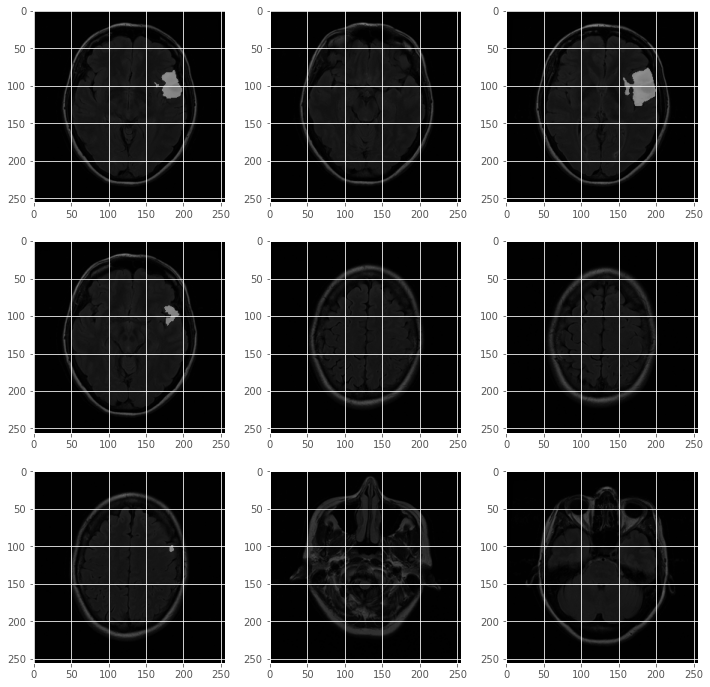

In [ ]:
utils.plot_from_img_path(3, 3 , image_filenames_train, mask_files )

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2836, 2)
(394, 2)
(709, 2)


In [ ]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [ ]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [ ]:
model = unet.unet()
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fc58c64a250>>

In [ ]:

train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet.unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss= utils.dice_coefficients_loss, metrics=["binary_accuracy", utils.iou, utils.dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=150, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

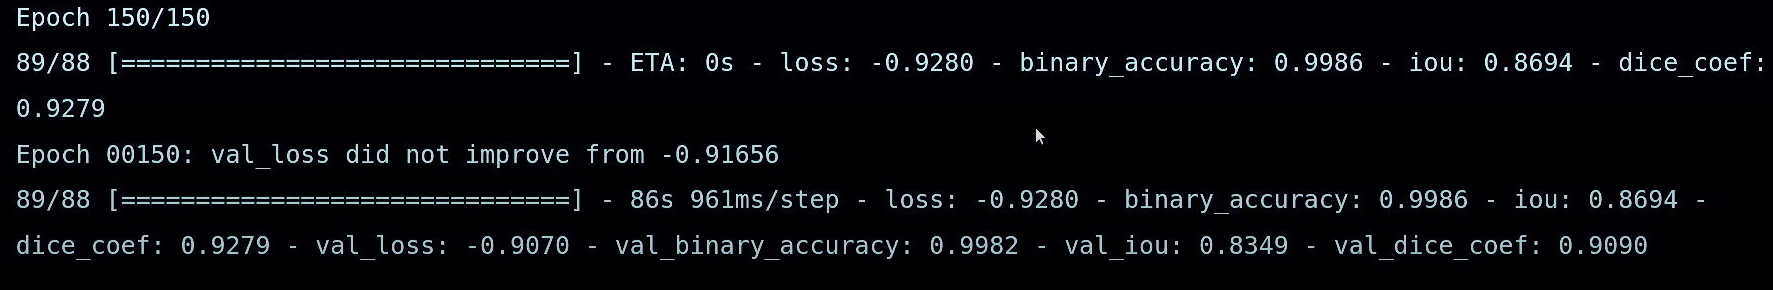

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficient']
test_dice_coeff_list = history_post_training['val_dice_coefficient']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

 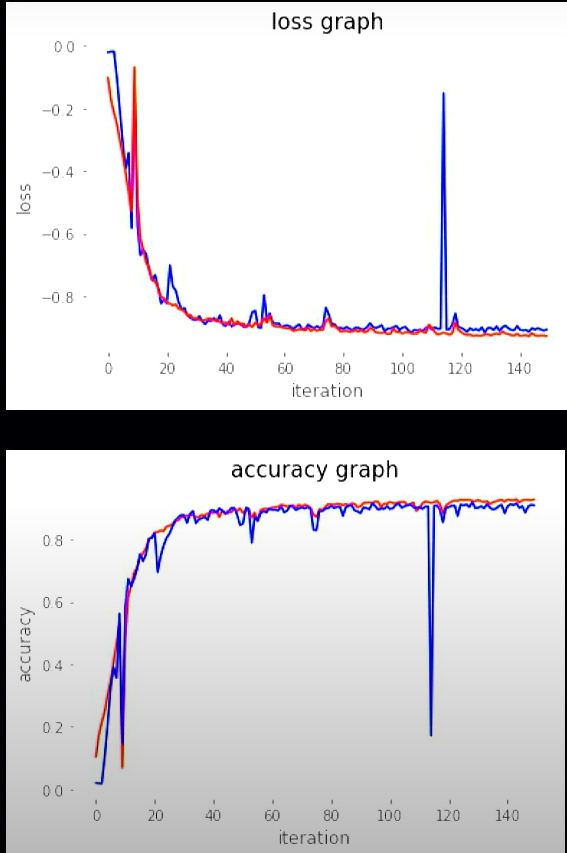

In [ ]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficient_loss': utils.dice_coefficients_loss, 'iou': utils.iou, 'dice_coefficient': utils.dice_coefficients  } )

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

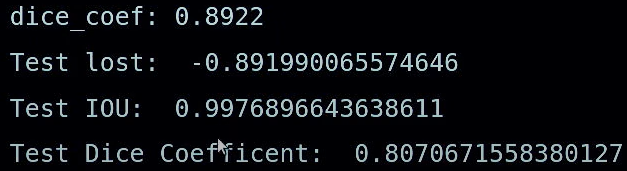

In [ ]:
for i in range(20):
    index = np.random.ranint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

In [ ]:
def detect_tumors(image, model):
    # Preprocess the image (e.g., resize, normalize, etc.)
    # ...
    
    # Make predictions using the model
    predictions = model.predict(np.expand_dims(image, axis=0))
    
    # Threshold the predictions to obtain binary mask
    mask = (predictions > 0.5).astype(np.uint8)
    
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding rectangles around the contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return image

def plot_images_with_tumors(image_filenames, model):
    for image_filename in image_filenames:
        # Read the image
        image = cv2.imread(image_filename)
        
        # Detect tumors and draw bounded regions
        image_with_tumors = detect_tumors(image, model)
        
        # Display the image with bounded regions
        plt.imshow(cv2.cvtColor(image_with_tumors, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


In [ ]:

# Call the function to plot images with bounded regions around tumors
plot_images_with_tumors(image_filenames_train, model)
